In [87]:
from src.datasources import glofas
import cdsapi
import xarray as xr
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd

GLOFAS_THRESH = 3130
GOOGLE_THRESH = 1212

In [ ]:
# We'll get the forecast data from today and the latest available reanalysis data 
# which we assume is from two days ago
today = datetime.now()
two_days_ago = today - timedelta(days=2)

c = cdsapi.Client()

2025-05-28 15:21:54,761 INFO [2024-09-26T00:00:00] Watch our [Forum]( https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


In [ ]:
# Get the pixel location
station = glofas.GF_STATIONS['wuroboki']
glofas_lon, glofas_lat = glofas.get_glofas_grid_coords(
    station["lon"], station["lat"]
)
pitch = 0.001
N = glofas_lat + pitch
S = glofas_lat
E = glofas_lon + pitch
W = glofas_lon

In [ ]:
# Get the forecast data for Wurobokki
forecast_dataset = "cems-glofas-forecast"
request = {
    "system_version": ["operational"],
    "hydrological_model": ["lisflood"],
    "product_type": ["control_forecast"],
    "variable": "river_discharge_in_the_last_24_hours",
    "year": [str(today.year)],
    "month": [str(today.month).zfill(2)],
    "day": [str(today.day).zfill(2)],
    "leadtime_hour": [
        "24",
        "48",
        "72",
        "96",
        "120",
    ],
    "data_format": "grib2",
    "download_format": "unarchived",
    "area": [N, W, S, E],
}

forecast_filename = f"glofas_forecast_monitored_{today.year}-{today.month}-{today.day}.grib"
forecast_response = c.retrieve(forecast_dataset, request)
forecast_response.download(f"temp/{forecast_filename}")

In [ ]:
# Get the reanalysis data for Wurobokki
reanalysis_dataset = "cems-glofas-historical"
request = {
    "system_version": ["version_4_0"],
    "hydrological_model": ["lisflood"],
    "product_type": ["intermediate"],
    "variable": ["river_discharge_in_the_last_24_hours"],
    "hyear": [str(two_days_ago.year)],
    "hmonth": [str(two_days_ago.month).zfill(2)],
    "hday": [str(two_days_ago.day).zfill(2)],
    "data_format": "grib2",
    "download_format": "unarchived",
    "area": [N, W, S, E]
}

# NOTE that we're saving the data with the date of MONITORING in the filename, not the date for which it is valid
reanalysis_filename = f"glofas_reforecast_monitored_{today.year}-{today.month}-{today.day}.grib"
reanalysis_response = c.retrieve(reanalysis_dataset, request)
reanalysis_response.download(f"temp/{reanalysis_filename}")

2025-05-28 15:26:18,841 INFO [2024-02-01T00:00:00] Please note that accessing this dataset via CDS for time-critical operation is not advised or supported
2025-05-28 15:26:18,842 INFO [2024-02-01T00:00:00] Please note we suggest checking the list of known issues on the GloFAS wiki
[here](https://confluence.ecmwf.int/display/CEMS/GloFAS+-+Known+Issues)
before downloading the dataset.
2025-05-28 15:26:18,843 INFO Request ID is af9bdda2-8692-4d6c-8758-1e3439cc6b83
2025-05-28 15:26:19,537 INFO status has been updated to accepted
2025-05-28 15:26:42,893 INFO status has been updated to running
2025-05-28 15:26:54,523 INFO status has been updated to successful


3f6d4f53d16507d072591164831ec208.grib:   0%|          | 0.00/244 [00:00<?, ?B/s]

'temp/glofas_reforecast_monitored_2025-5-28.grib'

In [ ]:
# Open the files 
ds_reanalysis = xr.open_dataset(f"temp/{reanalysis_filename}", engine="cfgrib",
    backend_kwargs={
        "indexpath": "",
    }
)
ds_forecast = xr.open_dataset(f"temp/{forecast_filename}", engine="cfgrib",
    backend_kwargs={
        "indexpath": "",
    }
)

/Users/hannahker/Desktop/ds-aa-nga-flooding/venv/lib/python3.13/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/hannahker/Desktop/ds-aa-nga-flooding/venv/lib/python3.13/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


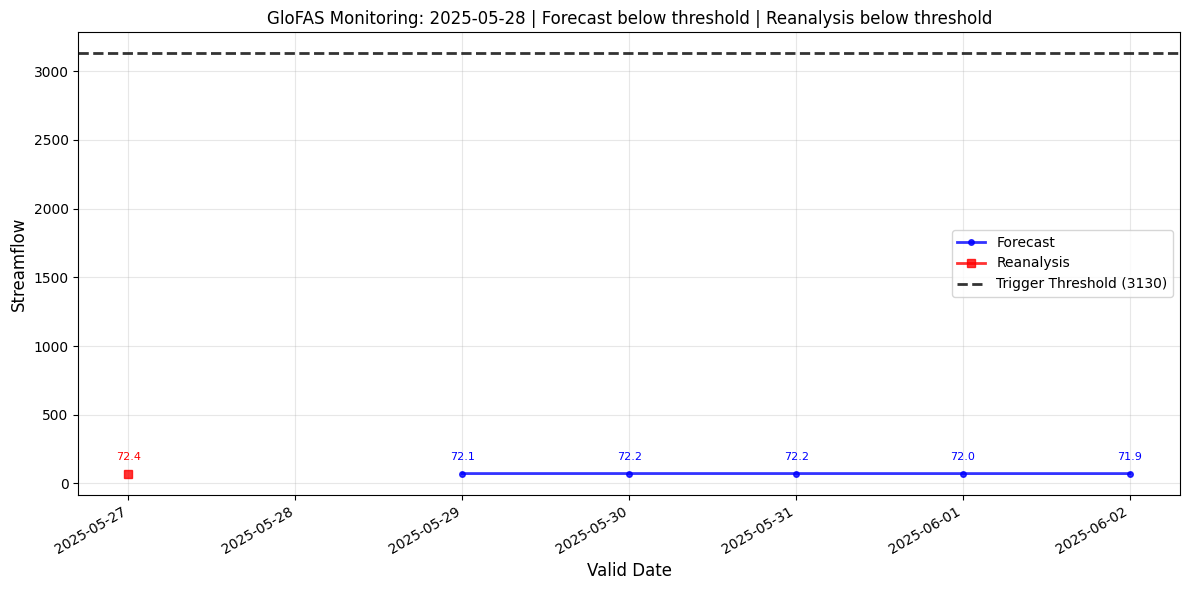

In [88]:
# Plot forecast data
# Convert valid_time to datetime if it's not already
df_forecast = ds_forecast.to_dataframe().reset_index()
df_forecast['valid_time'] = pd.to_datetime(df_forecast['valid_time'])

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(df_forecast['valid_time'], df_forecast['dis24'], 
        marker='o', linestyle='-', linewidth=2, markersize=4,
        label='Forecast', color='blue', alpha=0.8)

# Add labels for forecast points
for i, row in df_forecast.iterrows():
    ax.annotate(f'{row["dis24"]:.1f}', 
                (row['valid_time'], row['dis24']),
                textcoords="offset points", 
                xytext=(0,10), 
                ha='center', fontsize=8, color='blue')

# Plot reanalysis data
df_reanalysis = ds_reanalysis.to_dataframe().reset_index()
df_reanalysis['valid_time'] = pd.to_datetime(df_reanalysis['valid_time'])

ax.plot(df_reanalysis['valid_time'], df_reanalysis['dis24'], 
        marker='s', linestyle='-', linewidth=2, markersize=6,
        label='Reanalysis', color='red', alpha=0.8)

# Add labels for reanalysis points
for i, row in df_reanalysis.iterrows():
    ax.annotate(f'{row["dis24"]:.1f}', 
                (row['valid_time'], row['dis24']),
                textcoords="offset points", 
                xytext=(0,10), 
                ha='center', fontsize=8, color='red')
    
# Check if values exceed threshold and create subtitle
forecast_exceeds = (df_forecast['dis24'] > GLOFAS_THRESH).any()
reanalysis_exceeds = (df_reanalysis['dis24'] > GLOFAS_THRESH).any()

title_parts = [f'GloFAS Monitoring: {today}']
if forecast_exceeds:
    title_parts.append("Forecast exceeds threshold")
else:
    title_parts.append("Forecast below threshold")

if reanalysis_exceeds:
    title_parts.append("Reanalysis exceeds threshold")
else:
    title_parts.append("Reanalysis below threshold")

title = " | ".join(title_parts)

# Add horizontal threshold line
ax.axhline(y=GLOFAS_THRESH, color='black', linestyle='--', linewidth=2, 
           label=f'Trigger Threshold ({GLOFAS_THRESH})', alpha=0.8)

ax.set_xlabel('Valid Date', fontsize=12)
ax.set_ylabel('Streamflow', fontsize=12)
ax.set_title(title)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

fig.autofmt_xdate()
plt.tight_layout()